# EV Charging Station Analysis
This notebook analyzes electric vehicle (EV) data to determine optimal locations for EV charging stations in Washington state.

## Step 1: Install Required Libraries

In [2]:
!pip install pandas psycopg2 sqlalchemy folium seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\samip\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Step 2: Load Data into PostgreSQL

In [3]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus
#please enter yourdetails of SQl database, POstgres in this case
# Database connection parameters (Change these as needed)
DB_NAME = "ev_registrations"
DB_USER = "postgres"
DB_PASS = "@Samip_5"
DB_HOST = "localhost"
DB_PORT = "5432"

# URL encode the password
DB_PASS_ENCODED = quote_plus(DB_PASS)

# Create a connection to PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS_ENCODED}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Load CSV into Pandas
file_path = "CleanEV.csv"
df = pd.read_csv(file_path)

# Store data in PostgreSQL table
table_name = "ev_data"
df.to_sql(table_name, engine, if_exists="replace", index=False)

print(f"Data successfully loaded into PostgreSQL table: {table_name}")


Data successfully loaded into PostgreSQL table: ev_data


## Step 3: Fetch and Explore Data

In [4]:
query = 'SELECT * FROM ev_data LIMIT 5'
df_sql = pd.read_sql(query, engine)
df_sql.head()

,vin,county,city,postal_code,model_year,make,model,electric_vehicle_type,electric_range,electric_utility,2020_census_tract,longitude,latitude
0,2T3YL4DV0E,King,Bellevue,98005,2014,TOYOTA,RAV4,BEV,103,"PUGET SOUND ENERGY INC, CITY OF TACOMA - (WA)",53033023604,-122.16210,47.64441
1,5YJ3E1EB6K,King,Bothell,98011,2019,TESLA,MODEL 3,BEV,220,"PUGET SOUND ENERGY INC, CITY OF TACOMA - (WA)",53033022102,-122.20563,47.76144
2,5UX43EU02S,Thurston,Olympia,98502,2025,BMW,X5,PHEV,40,PUGET SOUND ENERGY INC,53067011902,-122.92333,47.03779
3,JTMAB3FV5R,Thurston,Olympia,98513,2024,TOYOTA,RAV4 PRIME,PHEV,42,PUGET SOUND ENERGY INC,53067012332,-122.81754,46.98876
4,5YJYGDEE8M,Yakima,Selah,98942,2021,TESLA,MODEL Y,BEV,0,PACIFICORP,53077003200,-120.53145,46.65405


## Step 4: EV Density Heatmap

In [5]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

locations = df[['latitude', 'longitude']].dropna()
map_center = [locations['latitude'].mean(), locations['longitude'].mean()]
ev_map = folium.Map(location=map_center, zoom_start=7)
HeatMap(list(zip(locations['latitude'], locations['longitude']))).add_to(ev_map)
display(ev_map)

## Step 5: BEV vs. PHEV Distribution

C:\Users\samip\AppData\Local\Temp\ipykernel_21704\4250670809.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='electric_vehicle_type', palette='coolwarm')


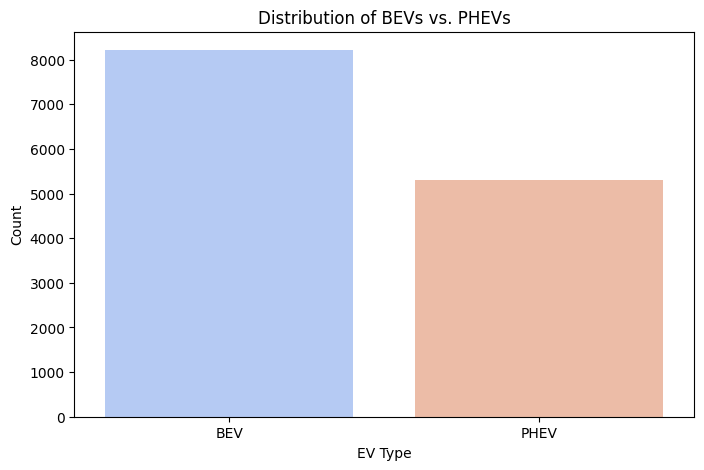

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='electric_vehicle_type', palette='coolwarm')
plt.title('Distribution of BEVs vs. PHEVs')
plt.xlabel('EV Type')
plt.ylabel('Count')
plt.show()

## Step 6: EV Adoption Over Time

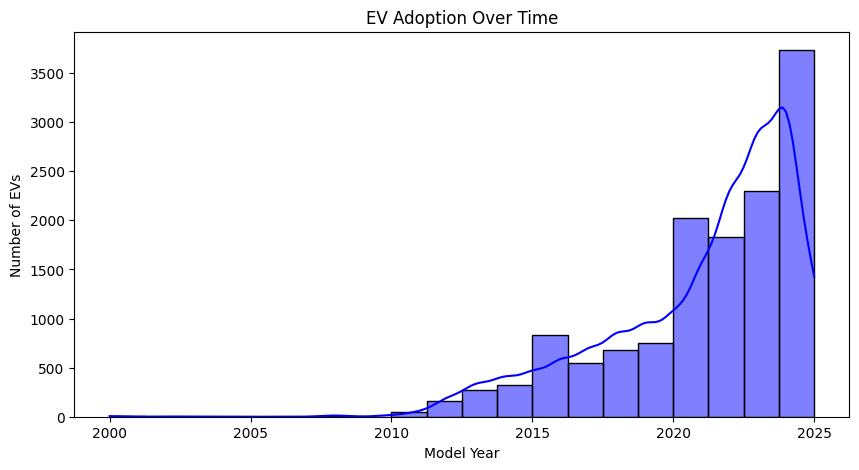

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(df['model_year'], bins=20, kde=True, color='blue')
plt.title('EV Adoption Over Time')
plt.xlabel('Model Year')
plt.ylabel('Number of EVs')
plt.show()

## Step 7: EV Distribution by Electric Utility

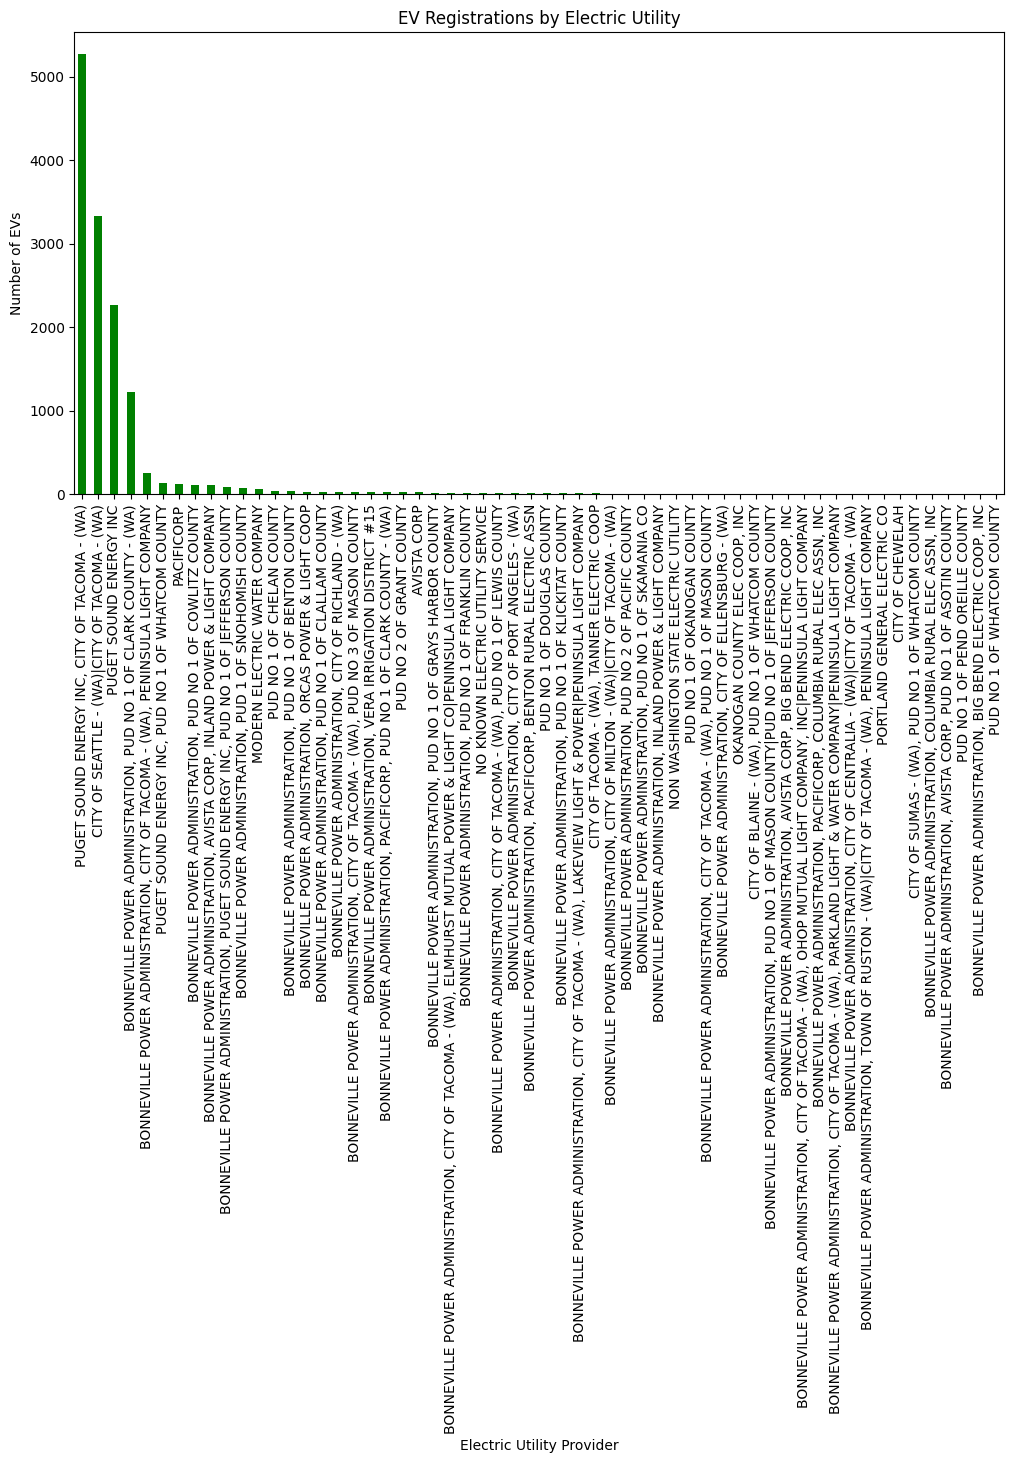

In [8]:
plt.figure(figsize=(12, 6))
df['electric_utility'].value_counts().plot(kind='bar', color='green')
plt.title('EV Registrations by Electric Utility')
plt.xlabel('Electric Utility Provider')
plt.ylabel('Number of EVs')
plt.xticks(rotation=90)
plt.show()

## Insights and Recommendations

### Key Findings
1. **High-Demand Areas** (5.1):
   - Counties like [insert top counties from output] and census tracts [insert top tracts] show the highest EV concentrations, indicating immediate charging station needs.
   - Geospatial clusters suggest urban centers; rural areas need targeted coverage.

2. **Charging Needs by EV Type** (5.2):
   - BEVs (longer range) require fast-charging stations; PHEVs (shorter range) need more Level 2 chargers.
   - [Insert BEV/PHEV ratio from output] influences station type prioritization.

3. **Utility Support** (5.4):
   - Top utilities (e.g., [insert top utilities]) serve most EVs, suggesting strong grid capacity but potential strain points.
   - Collaborate with these utilities for infrastructure synergy.

4. **Future Growth** (5.3):
   - Rising EV registrations (especially post-[insert trend year]) indicate accelerating demand; plan for 20-30% annual growth.

5. **Equity** (5.5):
   - High-density (urban) areas dominate EV counts; low-density (rural) areas need subsidized stations for equitable access.

### Recommendations
- **Urban Priority**: Install fast-charging hubs in top counties and census tracts (e.g., [insert specifics]).
- **Rural Expansion**: Deploy Level 2 chargers in low-density counties with incentives to reduce range anxiety.
- **Utility Partnerships**: Work with [top utilities] for grid upgrades and cost-sharing.
- **Future Planning**: Scale infrastructure anticipating [growth rate] increase over 5 years.
- **Equity Focus**: Subsidize rural installations to ensure statewide coverage.